In [ ]:
#    # Create and deploy an Azure Machine Learning web service

Although web services can be created directly within [Azure ML Studio](https://studio.azureml.net), in some cases it may be more straightforward to develop and deploy a web service entirely within a Python notebook. Python notebooks allow rapid prototyping and allow developers to include commentary in Markdown. This tutorial demonstrates how the [`azureml`](https://github.com/Azure/Azure-MachineLearning-ClientLibrary-Python) package can be used to deploy Azure ML web services directly from within a Python notebook (or other Python environment).

> **Note**: the `azureml` package presently works only with Python 2; be sure to set the notebook's kernel appropriately.

In this notebook:
- [Prerequisites](#Prerequisites)
   - [Credentials needed to connect to your workspace](#Credentials-needed-to-connect-to-your-workspace)
- [Explore beaver fever](#explore-beaver-fever)
   - [Loading and exploring the dataset](#Loading-and-exploring-the-dataset)
   - [Transferring data to and from Azure ML Studio](#Transferring-data-to-and-from-Azure-ML-Studio)
- [Creating the predictive model](#Creating-the-predictive-model)
- [Deploying the model as a web service](#Deploying-the-model-as-a-web-service)
- [Consuming the web service](#Consuming-the-web-service)

Refer to the [azureml GitHub repository](https://github.com/Azure/Azure-MachineLearning-ClientLibrary-Python) for more information on its capabilities.

## Prerequisites

This walkthrough assumes that you're familiar with Python and [Azure ML Studio](https://studio.azureml.net). You also need a workspace in Azure ML Studio and its credentials, which is described in the next section.

Your environment also requires the `azureml` package, which is installed by default with Azure Notebooks.

### Create and connect to an Azure ML Studio workspace

The `azureml` package uses your workspace ID and authorization token to connect to the workspace, provide that you're the owner of the workspace (authorized users who are not owners need to ask an owner for these details):

1. Open [Azure ML Studio](https://studio.azureml.net) in a browser and sign in with a Microsoft Account. Azure ML Studio is free and doesn't require an Azure subscription. Once signed in, you're in your "workspace."

1. Select the **Settings** button on the left pane:

    ![Settings button](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-settings.png?raw=true)<br/><br/>

1. On the **Name** tab, the **Workspace ID** field contains your workspace ID. Copy that ID into the `workspace_id` value in the code cell that follows.

    ![Location of workspace ID](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-workspace-id.png?raw=true)<br/><br/>

1. Select the **Authorization Tokens** tab and copy either token into the `authorization_token` value in the code cell that follows.

    ![Location of authorization token](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-tokens.png?raw=true)<br/><br/>

1. Run the code cell; if it runs without error, you're ready to continue.

In [7]:
from azureml import Workspace

# Replace the values with those from your own Azure ML Studio instance; see Prerequisites
# The workspace_id is a string of hexadecimal characters; the toke is a long string of random characters.
workspace_id = 'your_workspace_id'
authorization_token = 'your_auth_token'

ws = Workspace(workspace_id, authorization_token)

## Explore beaver fever

Reynolds (1994) collected data on the body temperatures of female beavers living in Wisconsin. We use this dataset to train a decision tree model which predicts a beaver's body temperature. Then we create a web service based on this model that can be used to predict body temperatures for other beavers.

> P. S. Reynolds (1994). "Time-series analyses of beaver body temperatures." Chapter 11 of Lange, N., Ryan, L., Billard, L., Brillinger, D., Conquest, L. and Greenhouse, J. eds (1994) *Case Studies in Biometry*. New York: John Wiley and Sons.

## Loading and exploring the dataset

Our dataset contains the following features:

- `time`: The time of day on which the recording was made
- `activ`: Binary indicator of whether activity is occurring outside of the beaver lodge
- `beaver`: The beaver being measured
- `temp`: The recorded body temperature

In [2]:
# Install the dataset
!pip install pydataset --disable-pip-version-check -q

Load the dataset and plot each of these features on the same axes to see whether any patterns may be present:

In [ ]:
import pandas as pd
from pydataset import data

df = data('beav1')
df['beaver'] = 1
df = pd.concat([df, data('beav2')], sort=True)
df.loc[df['beaver'].isnull(), 'beaver'] = 2
df.drop('day', 1, inplace=True)

%matplotlib inline
from ggplot import *
ggplot(aes(x='time', y='temp', color='beaver'), data=df) + geom_point()

Plotting the data reveals some conspicuous patterns. Beavers tend to be warmer when there is activity nearby, which tends to be in the afternoon and evening hours:

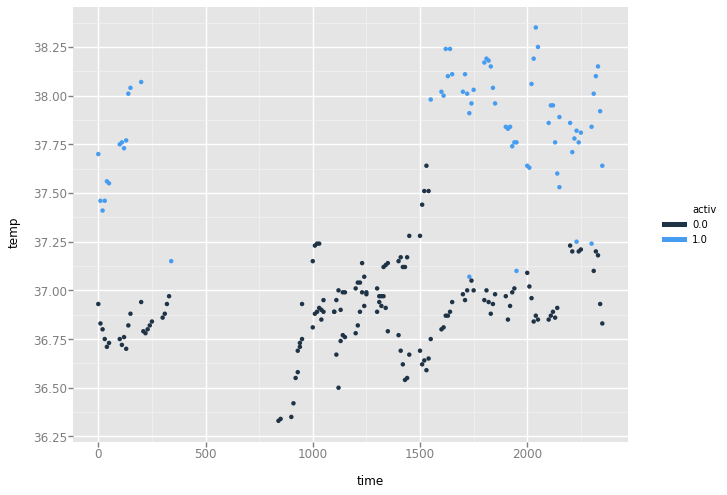

<ggplot: (8775673021009)>

In [4]:
ggplot(aes(x='time', y='temp', color='activ'), data=df) + geom_point()

It also appears that all else being equal, Beaver 2 is warmer than Beaver 1.

Notice that some trends seem to apply to a subset of the data. For example, if the measurement is from Beaver 2 *and* the beaver was active, then the body temperature is likely to be above 37.5; otherwise, the temperature is likely below 37.5. When trends apply to observation subsets that can be clearly defined using thresholding, decision tree models are good candidates. We therefore implement a decision tree model in the next section of the tutorial.

### Transferring data to and from Azure ML Studio

In this section, you create a predictive model entirely in Azure Notebooks. (You can also use the `azureml` Python program to transfer the data over to Azure ML Studio to create your model there.)

In [17]:
# This code is repeated from the Prerequisites section

from azureml import Workspace

# Replace the values with those from your own Azure ML Studio instance; see Prerequisites
# The workspace_id is a string of hexadecimal characters; the toke is a long string of random characters.
workspace_id = 'your_workspace_id'
authorization_token = 'your_auth_token'

ws = Workspace(workspace_id, authorization_token)

In [18]:
from azureml import DataTypeIds

dataset = ws.datasets.add_from_dataframe(
              dataframe=df,
              data_type_id=DataTypeIds.GenericCSV,
              name='Beaver Body Temperature Data',
              description='From Reynolds 1994 via pydataset'
          )

After running the code above, you can see the dataset listed in the **Datasets** section of the workspace (you may need to refresh the page):

![Dataset shown in Azure ML Studio](https://github.com/Microsoft/AzureNotebooks/blob/master/Samples/images/azure-ml-studio-dataset.png?raw=true)<br/>

It is also straightforward to list the datasets available in the workspace and transfer datasets from the workspace to the notebook:

In [19]:
print('\n'.join([i.name for i in ws.datasets if not i.is_example])) # only list user-created datasets

Beaver Body Temperature Data


In [20]:
# Read some more of the metadata
ds = ws.datasets['Beaver Body Temperature Data']
print(ds.name)
print(ds.description)
print(ds.family_id)
print(ds.data_type_id)
print(ds.created_date)
print(ds.size)

# Read the contents
df2 = ds.to_dataframe()
df2.head()

Beaver Body Temperature Data
From Reynolds 1994 via pydataset
abe2e90f1544425999981e5e637982ea
GenericCSV
2018-11-27 17:18:36.802000
3579


,activ,beaver,temp,time
0,0,1.0,36.33,840
1,0,1.0,36.34,850
2,0,1.0,36.35,900
3,0,1.0,36.42,910
4,0,1.0,36.55,920


## Creating the predictive model

To assess overfitting, train your decision tree using only a subset of the available data. You can then assess performance using the withheld observation. Below, `sklearn`'s `train_test_split()` function is used to select 70% of the data points for training and 30% for validation.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        df[['activ', 'beaver', 'time']],
        df['temp'],
        test_size=0.3,
        random_state=42
    )

Fit `scikit-learn`'s `DecisionTreeRegressor` model using the training data, then make predictions about the withheld body temperature measurements:

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_test_predictions = regressor.predict(X_test)
print('R^2 for true vs. predicted test set temperature measurements: {:0.2f}'.format(r2_score(y_test, y_test_predictions)))

R^2 for true vs. predicted test set temperature measurements: 0.94


It seems like this is a reasonably accurate model!

## Deploying the model as a web service

To deploy your model as a predictive web service, create a wrapper function that takes input data as an argument and calls `predict()` with your trained model and this input data, returning the results.

In [23]:
from azureml import services

@services.publish(workspace_id, authorization_token)
@services.types(activ=int, beaver=float, time=int)
@services.returns(float)

# The name of your web service is set to this function's name
def beaver_body_temp_predictor(activ, beaver, time):
    return regressor.predict([activ, beaver, time])

# Hold onto information about your web service so you can call it within the notebook later
service_url = beaver_body_temp_predictor.service.url 
api_key = beaver_body_temp_predictor.service.api_key
help_url = beaver_body_temp_predictor.service.help_url
service_id = beaver_body_temp_predictor.service.service_id

## Consuming the web service

While you are in the notebook session in which the web service was created, you can call the predictor directly:

In [24]:
                                                                                            beaver_body_temp_predictor.service(0, 1, 1200)

36.78

At any later time, you can use the stored API key and service URL to call the service:

#        import urllib2
import json

data = {"Inputs": { 
            "input1": {
                "ColumnNames": [ "beaver", "activ", "time"],
                "Values": [["1", "0", "1200"]] 
            }
        }, # specified feature values
        
        "GlobalParameters": {}
    }

body = json.dumps(data)
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
req = urllib2.Request(service_url, body, headers) 

try:
    response = urllib2.urlopen(req)
    result = json.loads(response.read())  # load json-formatted string response as dictionary
    print(result['Results']['output1']['value']['Values'][0][0]) # get the returned prediction
    
except urllib2.HTTPError, error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(json.loads(error.read()))         